In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('/kaggle/input/fidelfolio-dataset/FidelFolio_Dataset.csv')

other_cols_object = [f"Feature{i}" for i in [4, 5, 6, 7, 9]]
other_cols_object.append(" Target 1 ")
other_cols_object.append(" Target 2 ")
other_cols_object.append(" Target 3 ")

for col in other_cols_object:
    # Convert to string first, then remove commas, then convert to float
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [2]:
# Sort and prepare data by time
df_sorted = df.sort_values(by=["Company", "Year"])

features=[f'Feature{i}' for i in range (1,29)]
num_cols=features

# Clean targets
targets = [' Target 1 ', ' Target 2 ', ' Target 3 ']
df[targets] = df[targets].apply(pd.to_numeric, errors='coerce')

# Fill NaNs with company-wise mean, then global mean as fallback
for target in targets:
    company_mean = df.groupby('Company')[target].transform(lambda x: x.fillna(x.mean()))
    global_mean = df[target].mean()
    df[target] = company_mean.fillna(global_mean)

# Fill NaNs for each feature by company-wise mean
for feature in features:
    feature_mean = df.groupby('Company')[feature].transform(lambda x: x.fillna(x.mean()))
    global_mean = df[feature].mean()
    df[feature] = feature_mean.fillna(global_mean)



In [3]:
# Winsorization: cap values outside IQR bounds
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

df[num_cols] = df[num_cols].apply(cap_outliers)


In [4]:
from sklearn.preprocessing import StandardScaler

# Exclude target columns from scaling
target_cols = [' Target 1 ', ' Target 2 ', ' Target 3 ']
feature_cols = num_cols

# Scale features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])


from sklearn.model_selection import train_test_split

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (19800, 28)
Test set size: (4951, 28)


Using device: cpu
Epoch 1/1000 - Loss: 93906.5673
Epoch 2/1000 - Loss: 92314.6167
Epoch 3/1000 - Loss: 92031.2042
Epoch 4/1000 - Loss: 91797.9223
Epoch 5/1000 - Loss: 91776.9423
Epoch 6/1000 - Loss: 91552.8258
Epoch 7/1000 - Loss: 91497.2942
Epoch 8/1000 - Loss: 91443.3035
Epoch 9/1000 - Loss: 91305.5798
Epoch 10/1000 - Loss: 91263.6475
Epoch 11/1000 - Loss: 93357.0658
Epoch 12/1000 - Loss: 91135.4113
Epoch 13/1000 - Loss: 91073.2864
Epoch 14/1000 - Loss: 90985.5393
Epoch 15/1000 - Loss: 90952.3249
Epoch 16/1000 - Loss: 90955.6335
Epoch 17/1000 - Loss: 90777.2589
Epoch 18/1000 - Loss: 90714.6067
Epoch 19/1000 - Loss: 90999.6367
Epoch 20/1000 - Loss: 90595.5528
Epoch 21/1000 - Loss: 90564.2146
Epoch 22/1000 - Loss: 90623.2071
Epoch 23/1000 - Loss: 90579.4823
Epoch 24/1000 - Loss: 90407.3602
Epoch 25/1000 - Loss: 90508.2877
Epoch 26/1000 - Loss: 90319.4474
Epoch 27/1000 - Loss: 90361.7597
Epoch 28/1000 - Loss: 90253.1270
Epoch 29/1000 - Loss: 90260.0864
Epoch 30/1000 - Loss: 90120.8452
E

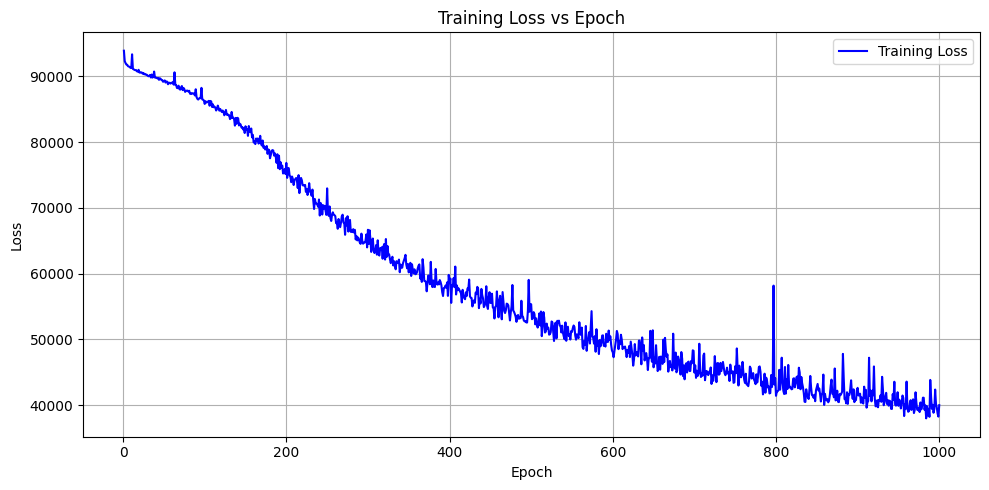

Test RMSE for  Target 1 : 106.3957
Test RMSE for  Target 2 : 207.7958
Test RMSE for  Target 3 : 366.3073


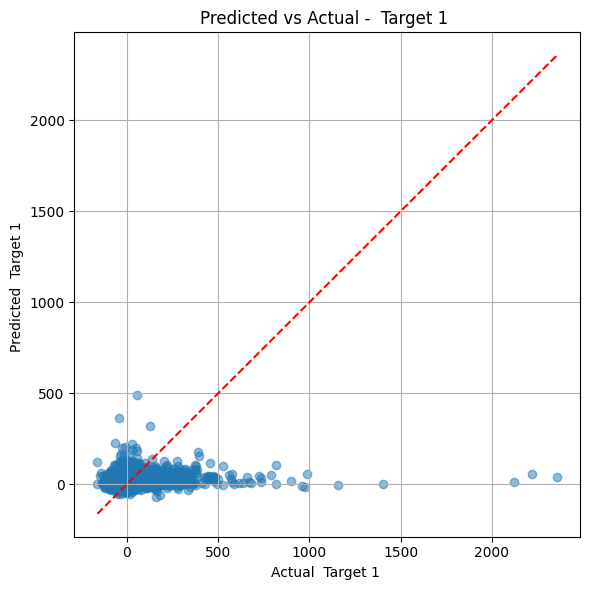

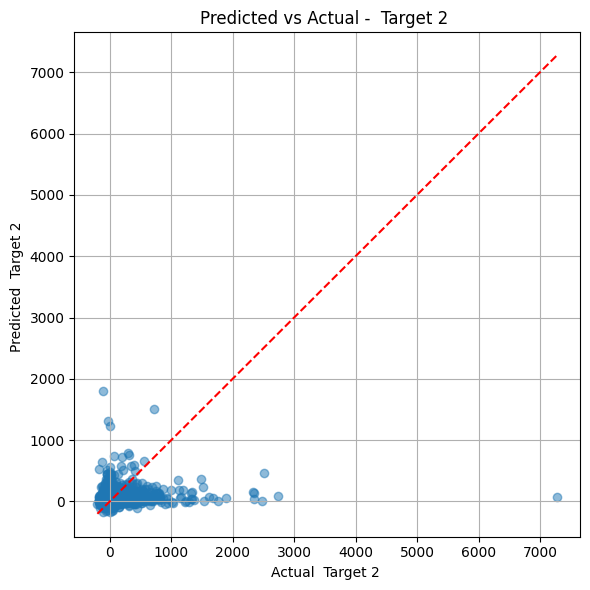

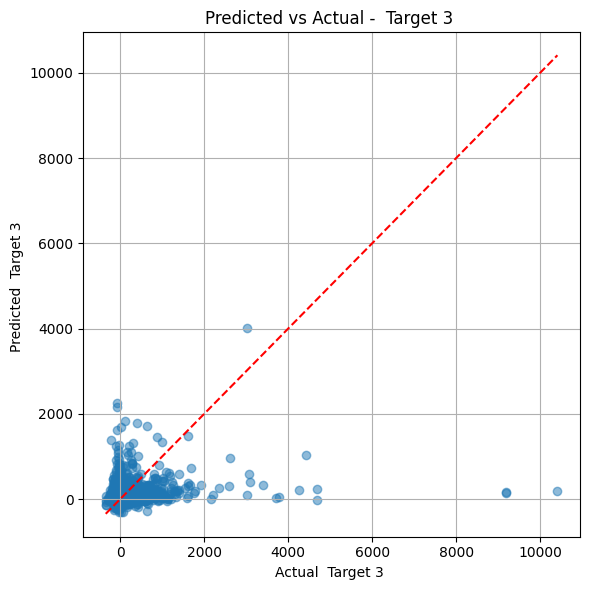

In [6]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader  
import torch.optim as optim
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.model(x)
# Convert to tensors (on CPU)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoaders with batch_size = 64
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=X_train.shape[1], output_size=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


import matplotlib.pyplot as plt

epochs = 1000
losses = []  # <-- Track losses here

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device) 
        yb = yb.to(device)  

        preds = model(xb)   # preds: (64, 3)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)  

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Plot loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


from sklearn.metrics import mean_squared_error
import numpy as np

# Set model to evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred_test = model(X_test_tensor.to(device)).cpu().numpy()
    y_true_test = y_test_tensor.cpu().numpy()

# Get the target column names
target_names = y_test.columns.tolist()


# Calculate RMSE for each target
for i, target in enumerate(target_names):
    rmse = mean_squared_error(y_true_test[:, i], y_pred_test[:, i], squared=False)
    print(f"Test RMSE for {target}: {rmse:.4f}")


import matplotlib.pyplot as plt

# Plot predicted vs actual for each target
for i, target in enumerate(target_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true_test[:, i], y_pred_test[:, i], alpha=0.5)
    plt.plot([y_true_test[:, i].min(), y_true_test[:, i].max()],
             [y_true_test[:, i].min(), y_true_test[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Predicted vs Actual - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


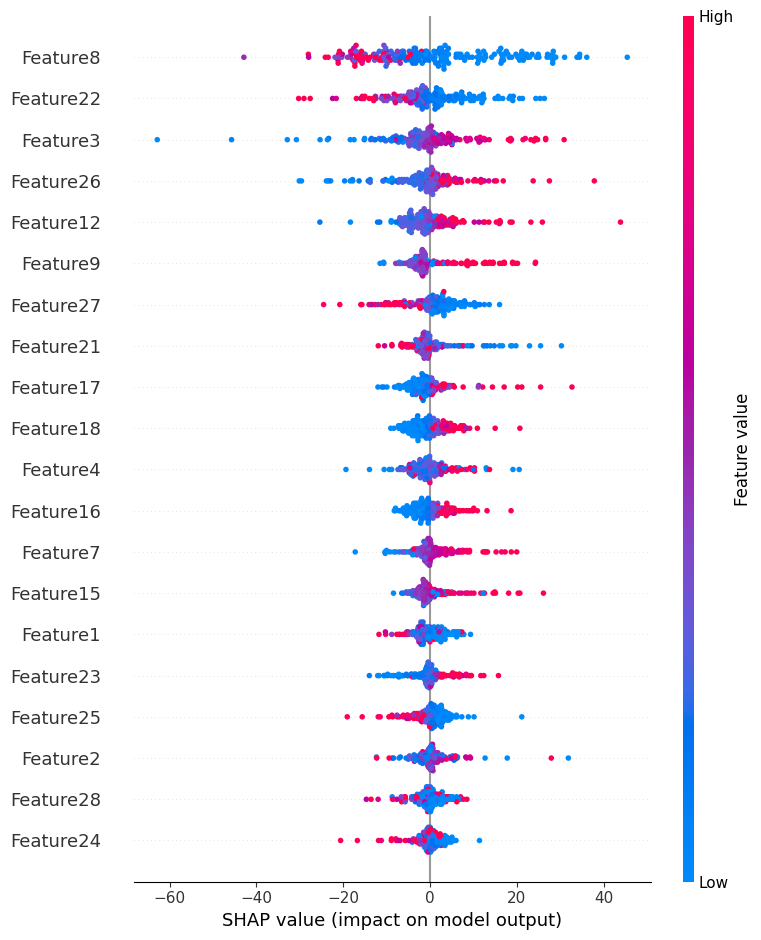

In [7]:
import shap

# Sample subset (for speed)
sample_idx = np.random.choice(len(X_test), size=200, replace=False)
X_shap = X_test.iloc[sample_idx]

# Convert to torch tensor
X_shap_tensor = torch.tensor(X_shap.values, dtype=torch.float32).to(device)

# Wrap model for SHAP
explainer = shap.DeepExplainer(model, torch.tensor(X_train.values[:1000], dtype=torch.float32).to(device))
shap_values = explainer.shap_values(X_shap_tensor)

# Plot SHAP summary for the first target
shap.summary_plot(shap_values[0], X_shap, feature_names=feature_cols, show=True)


In [8]:
from lime import lime_tabular
def predict_fn(input_np):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_np, dtype=torch.float32).to(device)
        outputs = model(input_tensor)
        return outputs.cpu().numpy()
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_cols,
    mode='regression',  # change to 'classification' if your task is classification
    verbose=True
)
idx = 0  # You can change this
instance = X_test.values[idx]
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_fn,
    num_features=10  # number of top features to display
)
exp.show_in_notebook(show_table=True)
# or
exp.as_list()  # for a list of feature contributions


Intercept 53.386963721666184
Prediction_local [-8.06187006]
Right: 13.299845


[('Feature22 > 0.46', -27.234316887593874),
 ('Feature4 > 0.46', -19.75355888433824),
 ('-0.72 < Feature17 <= -0.51', -17.755365259284602),
 ('Feature3 > 0.55', 15.957948502328197),
 ('Feature10 > 0.42', 15.823000244769258),
 ('-0.51 < Feature8 <= 0.36', -8.895822291554756),
 ('-0.36 < Feature21 <= 0.41', -6.105941699959214),
 ('Feature11 <= -0.40', -5.918594090310948),
 ('-0.37 < Feature1 <= 0.48', -4.165811491222604),
 ('-0.37 < Feature26 <= 0.40', -3.400371926172284)]

In [9]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results = pd.DataFrame()

# Add actual values
for i, target in enumerate(target_names):
    results[f'Actual_{target}'] = y_true_test[:, i]

# Add predicted values
for i, target in enumerate(target_names):
    results[f'Predicted_{target}'] = y_pred_test[:, i]

# Save to CSV with the desired name
results.to_csv("MLP_results.csv", index=False)

print("Saved predictions and actual values to MLP_results.csv")


Saved predictions and actual values to MLP_results.csv


In [10]:
torch.save(model.state_dict(), 'fidelfolio_model_MLP.pkt')
print("Model saved as fidelfolio_model.pkt")


Model saved as fidelfolio_model.pkt


**LSTM**

In [11]:
# Sort and prepare data by time
df_sorted = df.sort_values(by=["Company", "Year"])

# Define input features and targets
features = [col for col in df.columns if 'Feature' in col]
targets = [' Target 1 ', ' Target 2 ', ' Target 3 ']

# Group by Company → Create sequences
sequences = []
target_seq = []


for company, group in df_sorted.groupby('Company'):
    
    group = group.reset_index(drop=True)
    if len(group) >= 3:
        X = group[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
        y = group[targets].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
        sequences.append(torch.tensor(X, dtype=torch.float32))
        target_seq.append(torch.tensor(y, dtype=torch.float32))


# Convert to padded sequences (same length)
from torch.nn.utils.rnn import pad_sequence
import torch

X_seq = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
y_seq = [torch.tensor(tgt, dtype=torch.float32) for tgt in target_seq]



To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/2000, Loss: 31262.1811
Epoch 2/2000, Loss: 31023.7083
Epoch 3/2000, Loss: 30893.9921
Epoch 4/2000, Loss: 30708.4006
Epoch 5/2000, Loss: 30504.0730
Epoch 6/2000, Loss: 30641.3888
Epoch 7/2000, Loss: 30275.6949
Epoch 8/2000, Loss: 30106.5545
Epoch 9/2000, Loss: 30222.2741
Epoch 10/2000, Loss: 30058.4742
Epoch 11/2000, Loss: 29807.7164
Epoch 12/2000, Loss: 29662.1021
Epoch 13/2000, Loss: 29420.2730
Epoch 14/2000, Loss: 29387.7949
Epoch 15/2000, Loss: 29283.8589
Epoch 16/2000, Loss: 29114.2284
Epoch 17/2000, Loss: 29195.1873
Epoch 18/2000, Loss: 30336.7666
Epoch 19/2000, Loss: 28860.3518
Epoch 20/2000, Loss: 28874.2923
Epoch 21/2000, Loss: 28659.4594
Epoch 22/2000, Loss: 28537.8453
Epoch 23/2000, Loss: 28473.2957
Epoch 24/2000, Loss: 28892.8036
Epoch 25/2000, Loss: 30514.4437
Epoch 26/2000, Loss: 28250.6684
Epoch 27/2000, Loss: 28183.4510
Epoch 28/2000, Loss: 28120.6337
Epoch 29/2000, Loss: 28069.3601
Epoch 30/2000, Loss: 27892.6543
Epoch 31/2000, Loss: 46076.8595
Epoch 32/2000, Lo

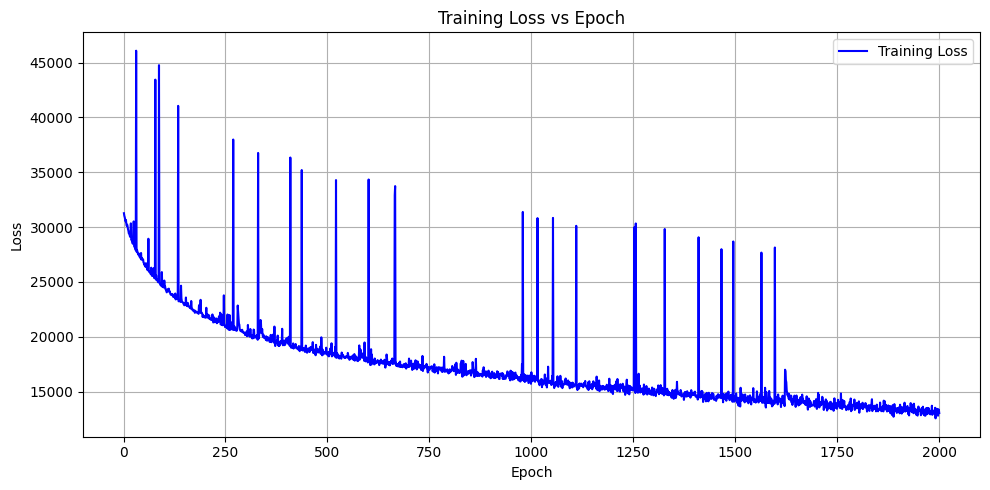

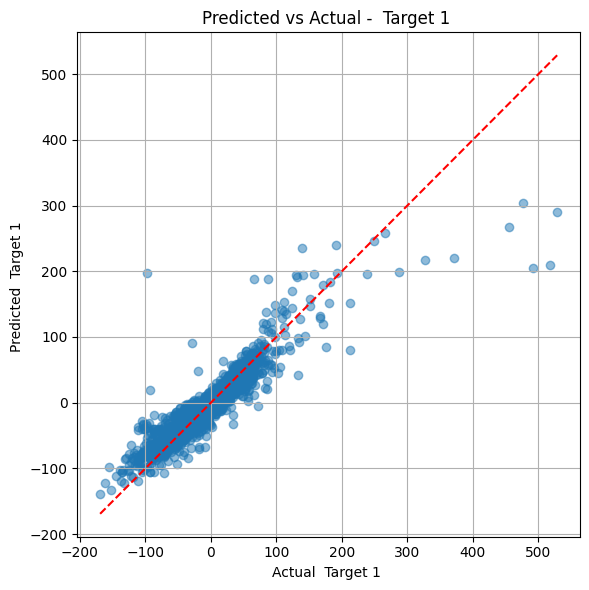

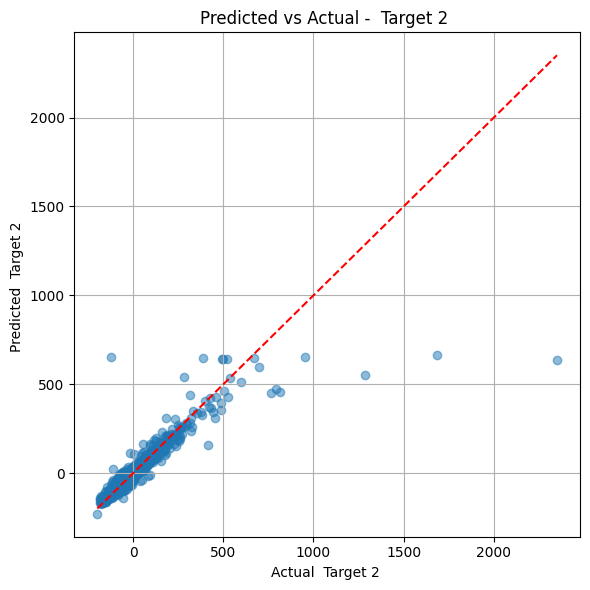

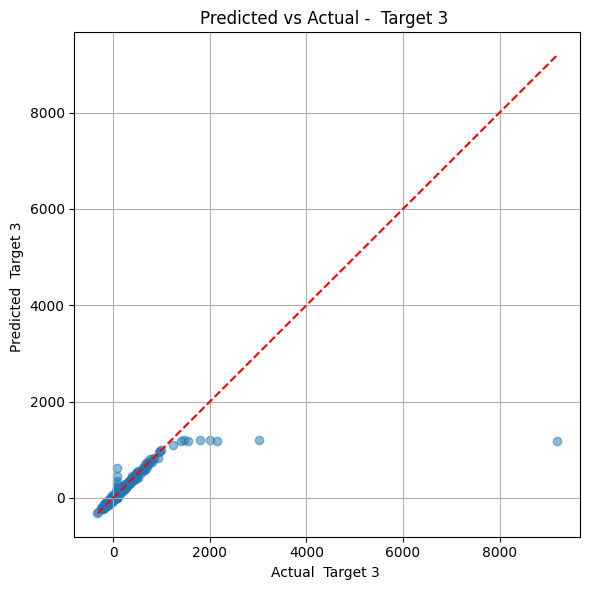

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
# Sort and prepare data by time

# Convert to padded sequences (same length)
from torch.nn.utils.rnn import pad_sequence
import torch

# 1. Sort and prepare data
features = [col for col in df.columns if 'Feature' in col]
targets = [' Target 1 ', ' Target 2 ', ' Target 3 ']
df_sorted = df.sort_values(by=["Company", "Year"])

sequences = []
target_seq = []

for company, group in df_sorted.groupby("Company"):
    group = group.reset_index(drop=True)
    if len(group) >= 3:
        X = group[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
        y = group[targets].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)
        sequences.append(torch.tensor(X))
        target_seq.append(torch.tensor(y[-1]))  # only the last target

# 2. Custom Dataset
task_dataset = list(zip(sequences, target_seq))

class LSTMDataset(Dataset):
    def __init__(self, sequence_data):
        self.data = sequence_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 3. Create DataLoader with list-based batching
def collate_fn(batch):
    X_list, y_list = zip(*batch)
    return list(X_list), list(y_list)

train_dataset = LSTMDataset(task_dataset)
data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# 4. Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, packed_x):
        packed_out, (hn, cn) = self.lstm(packed_x)
        out = self.dropout(hn[-1])  # last hidden state from top layer
        return self.fc(out)

# 5. Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = LSTMModel(input_size=len(features), hidden_size=64, output_size=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)


import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_sequence

epochs = 2000
losses = []

for epoch in range(epochs):
    model1.train()
    total_loss = 0
    for X_list, Y_list in data_loader:
        packed_x = pack_sequence([x.to(device) for x in X_list], enforce_sorted=False)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred = model1(packed_x)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model1.eval()
preds1 = []
actuals1 = []

with torch.no_grad():
    for X_list, Y_list in data_loader:
        packed_x = pack_sequence([x.to(device) for x in X_list], enforce_sorted=False)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred1 = model1(packed_x)
        preds1.append(pred1.cpu())

        actuals1.append(y_batch.cpu())

# Stack all batches into single arrays
preds1 = torch.cat(preds1).numpy()
actuals1 = torch.cat(actuals1).numpy()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# Plot predicted vs actual for each target
for i, target in enumerate(target_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals1[:, i], preds1[:, i], alpha=0.5)
    plt.plot([actuals1[:, i].min(), actuals1[:, i].max()],
             [actuals1[:, i].min(), actuals1[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Predicted vs Actual - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
for i, target in enumerate(target_names):
    rmse = mean_squared_error(actuals1[:, i], preds1[:, i], squared=False)
    print(f"Test RMSE for {target}: {rmse:.4f}")


Test RMSE for  Target 1 : 23.1415
Test RMSE for  Target 2 : 57.5375
Test RMSE for  Target 3 : 187.3309


In [14]:
# LIME in LSTM 
def flatten_last_k(seq_list, k=5):
    flat_X = []
    for seq in seq_list:
        seq_np = seq.numpy()
        if len(seq_np) >= k:
            trimmed = seq_np[-k:]  # last k timesteps
        else:
            # pad with zeros if shorter
            pad_len = k - len(seq_np)
            trimmed = np.concatenate([np.zeros((pad_len, seq_np.shape[1])), seq_np])
        flat_X.append(trimmed.flatten())
    return np.array(flat_X)

# Create flat dataset for LIME
X_flat = flatten_last_k(sequences, k=5)  # shape: [num_samples, k * num_features]
y_flat = np.stack(target_seq)


def reconstruct_sequence_from_flat(flat_array, k=5):
    """Convert flat vector back into a sequence tensor of shape [k, num_features]"""
    return torch.tensor(flat_array.reshape(k, -1), dtype=torch.float32)

def predict_fn_lime(input_np):
    model1.eval()
    input_seqs = []
    for flat_seq in input_np:
        seq_tensor = reconstruct_sequence_from_flat(flat_seq, k=5).to(device)
        input_seqs.append(seq_tensor)
    
    with torch.no_grad():
        packed_batch = pack_sequence(input_seqs, enforce_sorted=False)
        outputs = model1(packed_batch)
        return outputs.cpu().numpy()


from lime import lime_tabular

feature_names = [f"{f}_t{t}" for t in range(5) for f in features]

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_flat,
    feature_names=feature_names,
    mode='regression',
    verbose=True
)


idx = 0  # index of the company-sequence you want to explain
exp = explainer.explain_instance(
    data_row=X_flat[idx],
    predict_fn=predict_fn_lime,
    num_features=10  # top-k features
)

# Show explanation
exp.show_in_notebook(show_table=True)


Intercept 36.916799973913754
Prediction_local [67.93487457]
Right: 5.02664


In [15]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_lstm = pd.DataFrame()

# Add actual values
for i, target in enumerate(target_names):
    results_lstm[f'Actual_{target.strip()}'] = actuals1[:, i]

# Add predicted values
for i, target in enumerate(target_names):
    results_lstm[f'Predicted_{target.strip()}'] = preds1[:, i]

# Save to CSV
results_lstm.to_csv("LSTM_results.csv", index=False)

print("Saved predictions and actual values to LSTM_results.csv")


Saved predictions and actual values to LSTM_results.csv


In [16]:
torch.save(model.state_dict(), 'fidelfolio_model_LSTM.pkt')
print("Model saved as fidelfolio_model.pkt")

Model saved as fidelfolio_model.pkt


LSTM witth attention Layer


Epoch 1/3000, Loss: 31169.6388
Epoch 2/3000, Loss: 31296.8849
Epoch 3/3000, Loss: 30968.1447
Epoch 4/3000, Loss: 30759.9549
Epoch 5/3000, Loss: 30566.0553
Epoch 6/3000, Loss: 30443.8134
Epoch 7/3000, Loss: 30489.5951
Epoch 8/3000, Loss: 30283.8570
Epoch 9/3000, Loss: 30102.5247
Epoch 10/3000, Loss: 30041.6862
Epoch 11/3000, Loss: 30257.3614
Epoch 12/3000, Loss: 29943.4424
Epoch 13/3000, Loss: 30064.3666
Epoch 14/3000, Loss: 29958.9128
Epoch 15/3000, Loss: 29845.8986
Epoch 16/3000, Loss: 29571.5106
Epoch 17/3000, Loss: 29548.4787
Epoch 18/3000, Loss: 29464.6858
Epoch 19/3000, Loss: 29497.2625
Epoch 20/3000, Loss: 29341.9463
Epoch 21/3000, Loss: 29430.0015
Epoch 22/3000, Loss: 29242.9899
Epoch 23/3000, Loss: 29271.4115
Epoch 24/3000, Loss: 29125.8516
Epoch 25/3000, Loss: 29572.7838
Epoch 26/3000, Loss: 29130.3932
Epoch 27/3000, Loss: 28921.2806
Epoch 28/3000, Loss: 28862.4296
Epoch 29/3000, Loss: 28804.7746
Epoch 30/3000, Loss: 28750.2118
Epoch 31/3000, Loss: 29226.7573
Epoch 32/3000, Lo

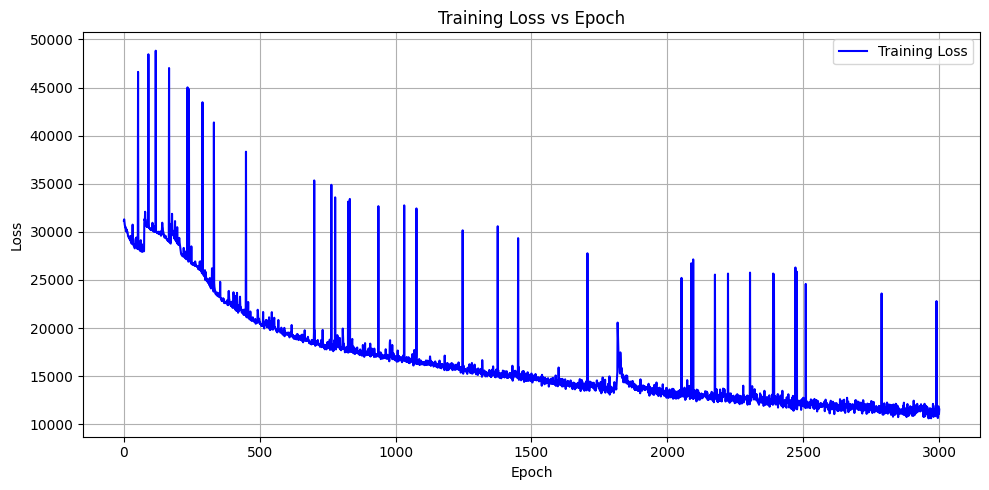

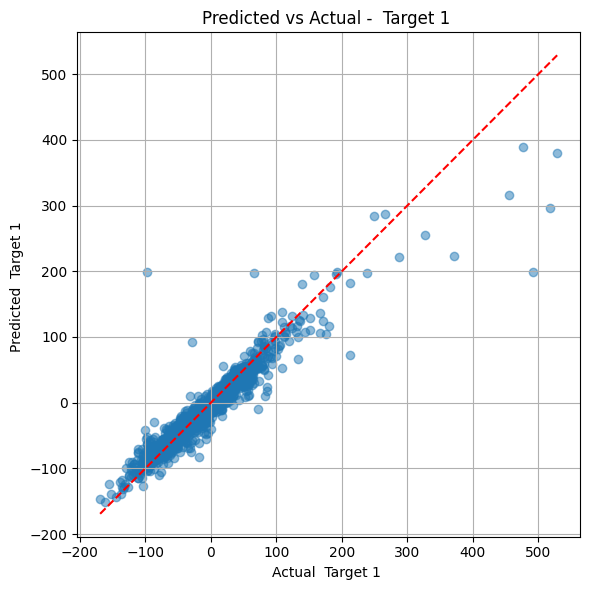

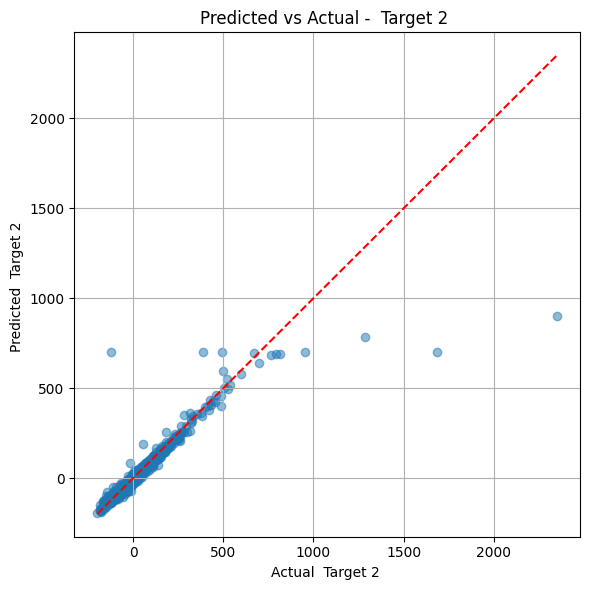

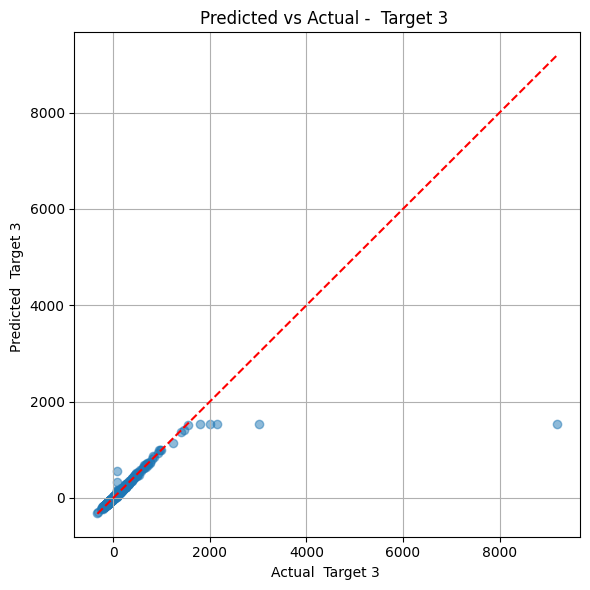

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence
import numpy as np
import pandas as pd

# Define the LSTM model with Attention
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attn_linear = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attention=False):
        lstm_out, _ = self.lstm(x)
        attn_scores = self.attn_linear(lstm_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.dropout(context)
        output = self.fc(out)
        
        if return_attention:
            return output, attn_weights
        return output


# Create dataset and loader
class LSTMDataset(Dataset):
    def __init__(self, sequence_data):
        self.data = sequence_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

task_dataset = list(zip(sequences, target_seq))
train_dataset = LSTMDataset(task_dataset)

def collate_fn(batch):
    X_list, y_list = zip(*batch)
    return list(X_list), list(y_list)

data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = LSTMAttentionModel(input_size=len(features), hidden_size=64, output_size=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)



losses = []  # Track average loss per epoch

# Train model
epochs = 3000
for epoch in range(epochs):
    model2.train()
    total_loss = 0
    for X_list, Y_list in data_loader:
        x_batch = torch.nn.utils.rnn.pad_sequence([x.to(device) for x in X_list], batch_first=True)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred = model2(x_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    losses.append(avg_loss)  # ✅ Append after epoch ends

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
# Evaluate
model2.eval()
preds2 = []
actuals2 = []

with torch.no_grad():
    for X_list, Y_list in data_loader:
        x_batch = torch.nn.utils.rnn.pad_sequence([x.to(device) for x in X_list], batch_first=True)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred2 = model2(x_batch)
        preds2.append(pred2.cpu())
        actuals2.append(y_batch.cpu())

preds2 = torch.cat(preds2).numpy()
actuals2 = torch.cat(actuals2).numpy()


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# Plot predicted vs actual for each target
for i, target in enumerate(target_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals2[:, i], preds2[:, i], alpha=0.5)
    plt.plot([actuals2[:, i].min(), actuals2[:, i].max()],
             [actuals2[:, i].min(), actuals2[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Predicted vs Actual - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
for i, target in enumerate(target_names):
    rmse = mean_squared_error(actuals2[:, i], preds2[:, i], squared=False)
    print(f"Test RMSE for {target}: {rmse:.4f}")


Test RMSE for  Target 1 : 18.3073
Test RMSE for  Target 2 : 47.7369
Test RMSE for  Target 3 : 175.6616


In [19]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_lstm = pd.DataFrame()

# Add actual values
for i, target in enumerate(target_names):
    results_lstm[f'Actual_{target.strip()}'] = actuals2[:, i]

# Add predicted values
for i, target in enumerate(target_names):
    results_lstm[f'Predicted_{target.strip()}'] = preds2[:, i]

# Save to CSV
results_lstm.to_csv("LSTM_with_attention_results.csv", index=False)

print("Saved predictions and actual values to LSTM_with_attention_results.csv")


Saved predictions and actual values to LSTM_with_attention_results.csv


In [20]:
torch.save(model.state_dict(), 'fidelfolio_model_LSTMAttention.pkt')
print("Model saved as fidelfolio_model.pkt")

Model saved as fidelfolio_model.pkt


Transformer

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd


# Define the Transformer model for time-series forecasting
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward, output_size, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, d_model))  # max seq_len = 500
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_linear(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        out = self.dropout(x[:, -1, :])  # last time step
        return self.fc_out(out)

# Prepare the data
features = [col for col in df.columns if 'Feature' in col]
targets = [' Target 1 ', ' Target 2 ', ' Target 3 ']
df_sorted = df.sort_values(by=["Company", "Year"])


# Create dataset and loader
class TimeSeriesDataset(Dataset):
    def __init__(self, sequence_data):
        self.data = sequence_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

task_dataset = list(zip(sequences, target_seq))
train_dataset = TimeSeriesDataset(task_dataset)

def collate_fn(batch):
    X_list, y_list = zip(*batch)
    return list(X_list), list(y_list)

data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = TransformerModel(
    input_size=len(features),
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    output_size=3
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [22]:
losses = []  # Initialize a list to store epoch-wise loss
epochs = 1200

for epoch in range(epochs):
    model3.train()
    total_loss = 0
    for X_list, Y_list in data_loader:
        x_batch = pad_sequence([x.to(device) for x in X_list], batch_first=True)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred = model3(x_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    losses.append(avg_loss)  # Append average loss per epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluate
model3.eval()
preds3 = []
actuals3 = []

with torch.no_grad():
    for X_list, Y_list in data_loader:
        x_batch = pad_sequence([x.to(device) for x in X_list], batch_first=True)
        y_batch = torch.stack([y.to(device) for y in Y_list])

        pred3 = model3(x_batch)
        preds3.append(pred3.cpu())
        actuals3.append(y_batch.cpu())

preds3 = torch.cat(preds3).numpy()
actuals3 = torch.cat(actuals3).numpy()


Epoch 1/1200, Loss: 31148.7182
Epoch 2/1200, Loss: 30949.0002
Epoch 3/1200, Loss: 31075.3276
Epoch 4/1200, Loss: 31689.4036
Epoch 5/1200, Loss: 30276.0048
Epoch 6/1200, Loss: 30044.4548
Epoch 7/1200, Loss: 31443.4646
Epoch 8/1200, Loss: 30658.5188
Epoch 9/1200, Loss: 29504.9906
Epoch 10/1200, Loss: 29270.2878
Epoch 11/1200, Loss: 29048.1230
Epoch 12/1200, Loss: 29642.0301
Epoch 13/1200, Loss: 29076.7944
Epoch 14/1200, Loss: 28694.4345
Epoch 15/1200, Loss: 28535.8423
Epoch 16/1200, Loss: 28219.1138
Epoch 17/1200, Loss: 28119.2455
Epoch 18/1200, Loss: 27795.0616
Epoch 19/1200, Loss: 28079.8331
Epoch 20/1200, Loss: 27607.8692
Epoch 21/1200, Loss: 27601.5517
Epoch 22/1200, Loss: 27462.0553
Epoch 23/1200, Loss: 27451.1411
Epoch 24/1200, Loss: 27271.0192
Epoch 25/1200, Loss: 27263.7324
Epoch 26/1200, Loss: 27274.2312
Epoch 27/1200, Loss: 27153.2795
Epoch 28/1200, Loss: 26873.6655
Epoch 29/1200, Loss: 27015.8833
Epoch 30/1200, Loss: 26912.2205
Epoch 31/1200, Loss: 26690.6794
Epoch 32/1200, Lo

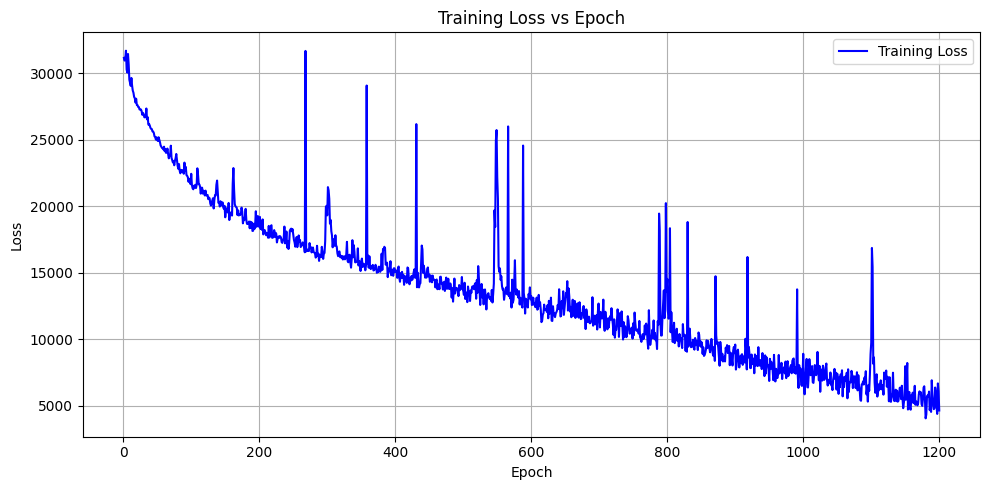

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


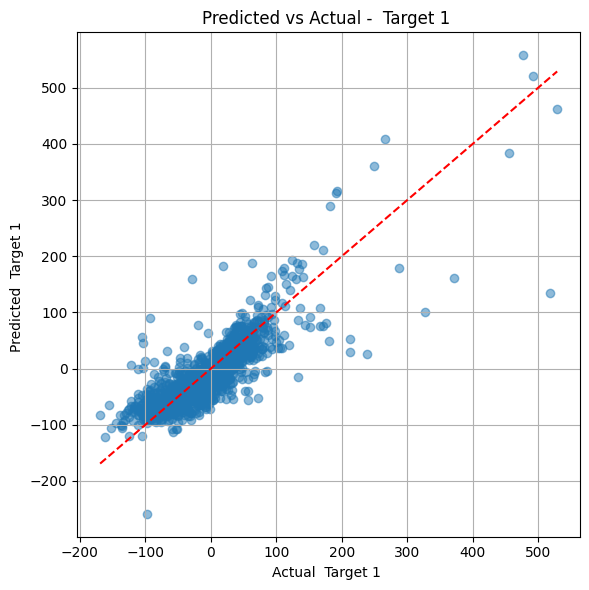

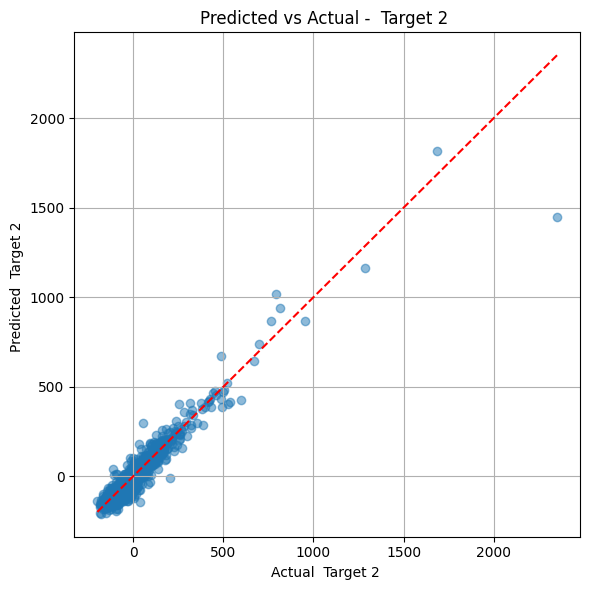

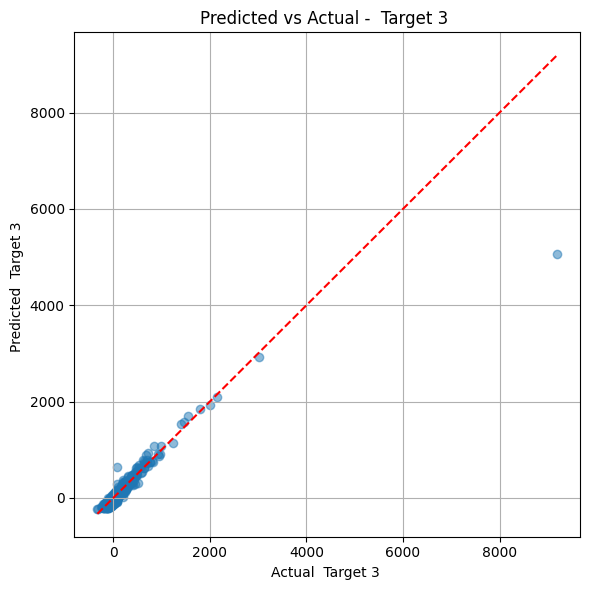

In [24]:
import matplotlib.pyplot as plt

# Plot predicted vs actual for each target
for i, target in enumerate(target_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals3[:, i], preds3[:, i], alpha=0.5)
    plt.plot([actuals3[:, i].min(), actuals3[:, i].max()],
             [actuals3[:, i].min(), actuals3[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Predicted vs Actual - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
for i, target in enumerate(target_names):
    rmse = mean_squared_error(actuals3[:, i], preds3[:, i], squared=False)
    print(f"Test RMSE for {target}: {rmse:.4f}")


Test RMSE for  Target 1 : 31.0871
Test RMSE for  Target 2 : 39.6811
Test RMSE for  Target 3 : 103.0818


In [26]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_lstm = pd.DataFrame()

# Add actual values
for i, target in enumerate(target_names):
    results_lstm[f'Actual_{target.strip()}'] = actuals3[:, i]

# Add predicted values
for i, target in enumerate(target_names):
    results_lstm[f'Predicted_{target.strip()}'] = preds3[:, i]

# Save to CSV
results_lstm.to_csv("Transformer_results.csv", index=False)

print("Saved predictions and actual values to Transformer_results.csv")


Saved predictions and actual values to Transformer_results.csv


In [27]:
torch.save(model.state_dict(), 'fidelfolio_model_transformer.pkt')
print("Model saved as fidelfolio_model.pkt")

Model saved as fidelfolio_model.pkt


**TabNet**

In [49]:
pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

Device used : cpu


epoch 0  | loss: 34329.44422| val_0_mse: 20413.59375|  0:00:00s
epoch 1  | loss: 33888.54787| val_0_mse: 19257.744140625|  0:00:01s
epoch 2  | loss: 32968.48628| val_0_mse: 18475.951171875|  0:00:02s
epoch 3  | loss: 32342.77597| val_0_mse: 18339.8984375|  0:00:02s
epoch 4  | loss: 32002.91443| val_0_mse: 18055.412109375|  0:00:03s
epoch 5  | loss: 31308.36228| val_0_mse: 18040.568359375|  0:00:04s
epoch 6  | loss: 31201.37275| val_0_mse: 18043.158203125|  0:00:04s
epoch 7  | loss: 31291.49766| val_0_mse: 18225.091796875|  0:00:05s
epoch 8  | loss: 30772.67657| val_0_mse: 17344.58984375|  0:00:06s
epoch 9  | loss: 30509.35368| val_0_mse: 17701.419921875|  0:00:07s
epoch 10 | loss: 30630.58168| val_0_mse: 17250.509765625|  0:00:07s
epoch 11 | loss: 30888.15192| val_0_mse: 17039.6015625|  0:00:08s
epoch 12 | loss: 30322.42894| val_0_mse: 16863.375|  0:00:09s
epoch 13 | loss: 30568.6418| val_0_mse: 17088.595703125|  0:00:09s
epoch 14 | loss: 30247.71493| val_0_mse: 16832.287109375|  0:00:

Best weights from best epoch are automatically used!


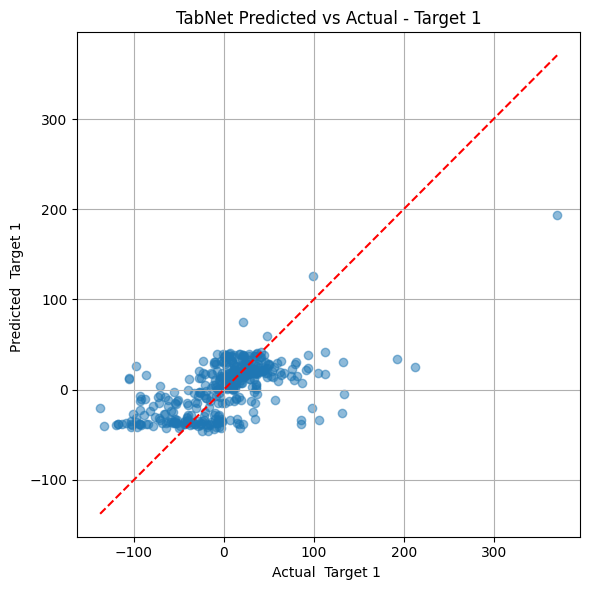

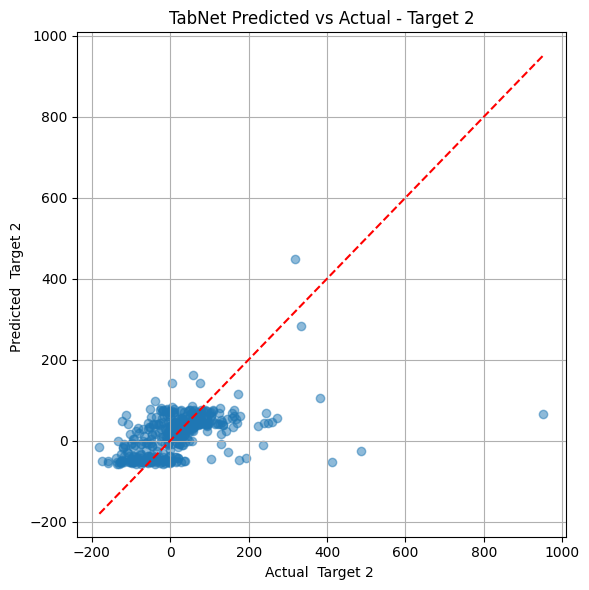

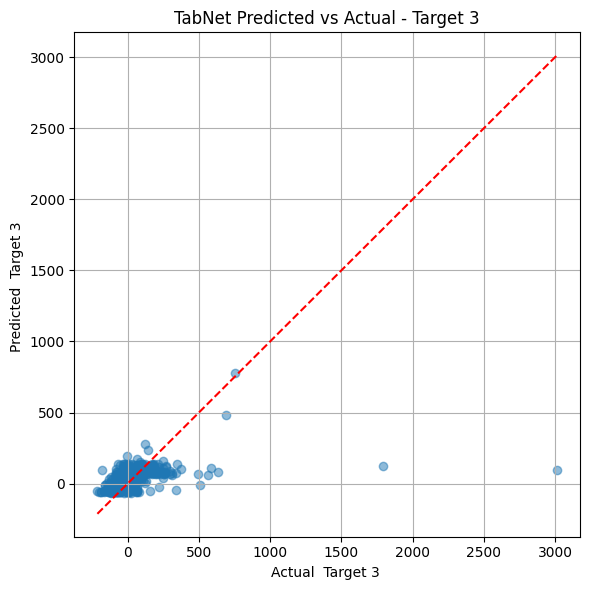

In [50]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Prepare TabNet data from the last known values of each sequence
tabnet_features = [col for col in df.columns if 'Feature' in col]
tabnet_targets = [' Target 1 ', ' Target 2 ', ' Target 3 ']

# Sorted
df_tabnet_sorted = df.sort_values(by=["Company", "Year"])

# Use only last time point per company for TabNet
X_tabnet = []
y_tabnet = []

for company, group in df_tabnet_sorted.groupby("Company"):
    group = group.reset_index(drop=True)
    if len(group) >= 3:
        x = group[tabnet_features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)[-1]
        y = group[tabnet_targets].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)[-1]
        X_tabnet.append(x)
        y_tabnet.append(y)

X_tabnet = np.array(X_tabnet)
y_tabnet = np.array(y_tabnet)

# 2. Split data
X_train_tabnet, X_test_tabnet, y_train_tabnet, y_test_tabnet = train_test_split(
    X_tabnet, y_tabnet, test_size=0.2, random_state=42
)

# 3. Normalize features
scaler_tabnet = StandardScaler()
X_train_tabnet = scaler_tabnet.fit_transform(X_train_tabnet)
X_test_tabnet = scaler_tabnet.transform(X_test_tabnet)

# 4. Train TabNet model
tabnet_model = TabNetRegressor()
tabnet_model.fit(
    X_train=X_train_tabnet, y_train=y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    max_epochs=2000,
    patience=50,
    batch_size=64,
    virtual_batch_size=16,
    num_workers=0,
    drop_last=False,
    loss_fn=torch.nn.MSELoss()
)

# 5. Predictions and evaluation
preds_tabnet = tabnet_model.predict(X_test_tabnet)

# 6. Plot predicted vs actual
import matplotlib.pyplot as plt

for i, target in enumerate(tabnet_targets):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_tabnet[:, i], preds_tabnet[:, i], alpha=0.5)
    plt.plot([y_test_tabnet[:, i].min(), y_test_tabnet[:, i].max()],
             [y_test_tabnet[:, i].min(), y_test_tabnet[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'TabNet Predicted vs Actual - {target.strip()}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [51]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE for each target
rmse_target1 = mean_squared_error(y_test_tabnet[:, 0], preds_tabnet[:, 0], squared=False)
rmse_target2 = mean_squared_error(y_test_tabnet[:, 1], preds_tabnet[:, 1], squared=False)
rmse_target3 = mean_squared_error(y_test_tabnet[:, 2], preds_tabnet[:, 2], squared=False)

# Print the results
print(f"TabNet RMSE for Target 1: {rmse_target1:.4f}")
print(f"TabNet RMSE for Target 2: {rmse_target2:.4f}")
print(f"TabNet RMSE for Target 3: {rmse_target3:.4f}")


TabNet RMSE for Target 1: 41.1473
TabNet RMSE for Target 2: 86.8142
TabNet RMSE for Target 3: 197.3770


**Multi-horizon** **TCN**

[TCN] Epoch 1/2000, Loss: 30976.0645
[TCN] Epoch 2/2000, Loss: 30267.7539
[TCN] Epoch 3/2000, Loss: 30000.6198
[TCN] Epoch 4/2000, Loss: 29817.3768
[TCN] Epoch 5/2000, Loss: 29701.2758
[TCN] Epoch 6/2000, Loss: 29534.4728
[TCN] Epoch 7/2000, Loss: 29455.1079
[TCN] Epoch 8/2000, Loss: 29234.4096
[TCN] Epoch 9/2000, Loss: 29153.2400
[TCN] Epoch 10/2000, Loss: 29580.5564
[TCN] Epoch 11/2000, Loss: 28657.1319
[TCN] Epoch 12/2000, Loss: 28672.1067
[TCN] Epoch 13/2000, Loss: 27933.0042
[TCN] Epoch 14/2000, Loss: 27824.4929
[TCN] Epoch 15/2000, Loss: 27894.0817
[TCN] Epoch 16/2000, Loss: 27222.2848
[TCN] Epoch 17/2000, Loss: 27325.0017
[TCN] Epoch 18/2000, Loss: 26638.6584
[TCN] Epoch 19/2000, Loss: 26726.3970
[TCN] Epoch 20/2000, Loss: 26170.1907
[TCN] Epoch 21/2000, Loss: 26054.1139
[TCN] Epoch 22/2000, Loss: 25866.3705
[TCN] Epoch 23/2000, Loss: 27117.1284
[TCN] Epoch 24/2000, Loss: 25378.1077
[TCN] Epoch 25/2000, Loss: 24741.9209
[TCN] Epoch 26/2000, Loss: 24943.3852
[TCN] Epoch 27/2000, 

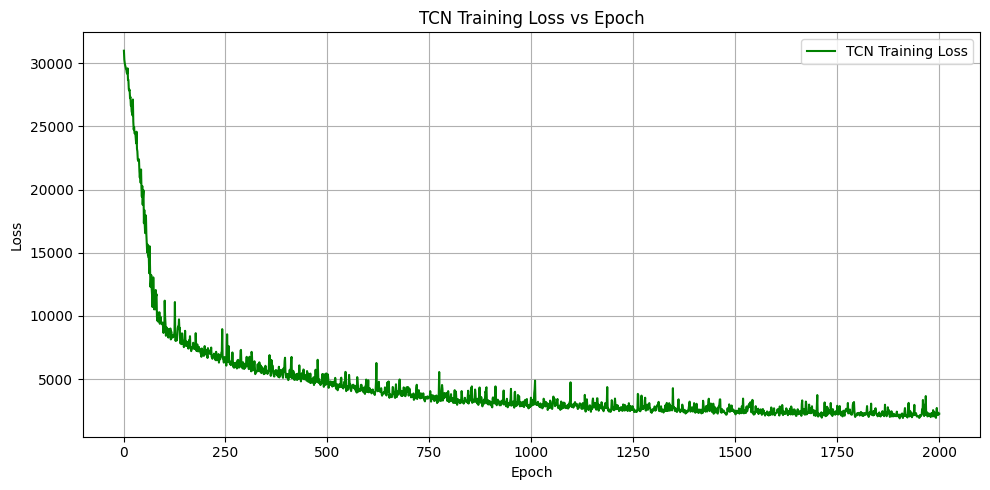

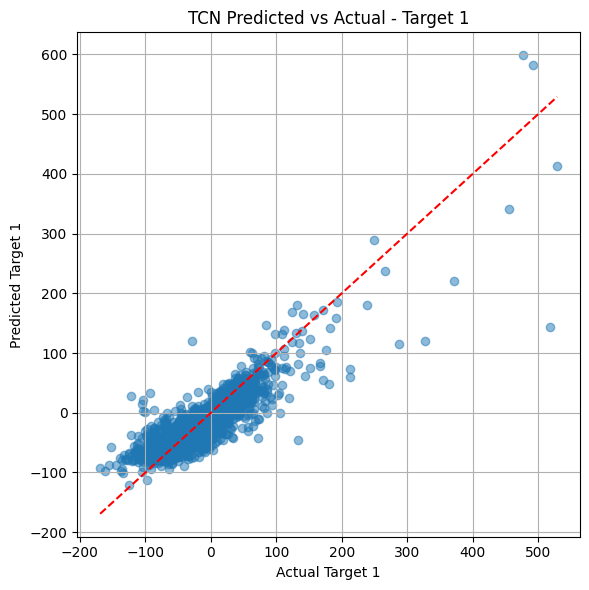

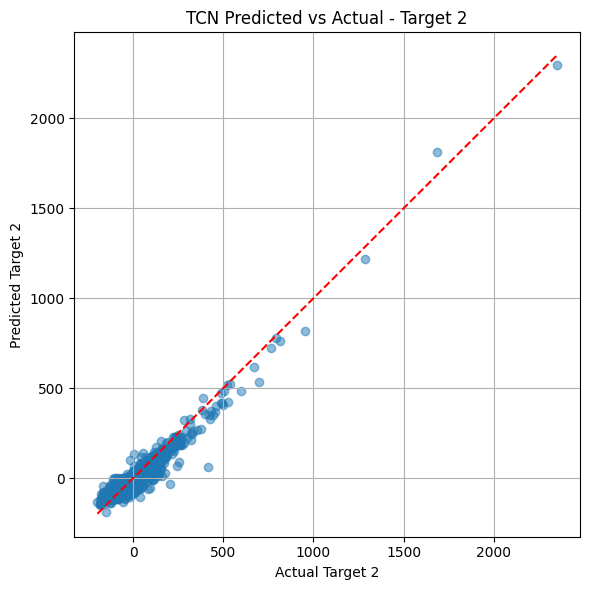

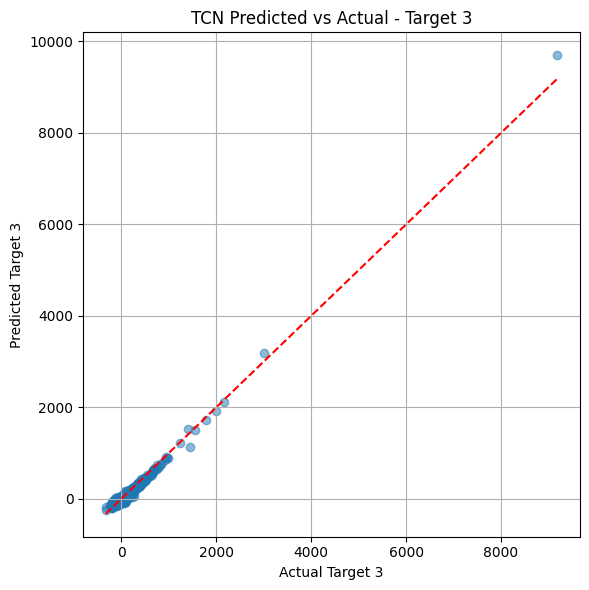

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# 1. Define TCN block
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               padding=(kernel_size - 1) * dilation, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.kernel_size = kernel_size
        self.dilation = dilation

    def forward(self, x):
        out = self.conv1(x)
        
        # Trim the output to match input sequence length
        trim = (self.kernel_size - 1) * self.dilation
        if trim > 0:
            out = out[:, :, :-trim]

        out = self.relu(out)
        out = self.dropout(out)
        return out + self.residual(x)


# 2. Full Multi-horizon TCN Model
class MarketCapTCN(nn.Module):
    def __init__(self, input_size, num_targets):
        super(MarketCapTCN, self).__init__()
        self.tcn_net = nn.Sequential(
            TCNBlock(input_size, 64, kernel_size=3, dilation=1),
            TCNBlock(64, 64, kernel_size=3, dilation=2),
            TCNBlock(64, 64, kernel_size=3, dilation=4)
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_out = nn.Linear(64, num_targets)

    def forward(self, x):
        # Input: [B, T, F] --> [B, F, T] for Conv1D
        x = x.permute(0, 2, 1)
        out = self.tcn_net(x)
        out = self.global_pool(out).squeeze(-1)
        return self.fc_out(out)

# 3. Custom Dataset and DataLoader
class TCNMarketDataset(Dataset):
    def __init__(self, sequence_data):
        self.data = sequence_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def tcn_collate_fn(batch):
    X_list, y_list = zip(*batch)
    X_padded = pad_sequence(X_list, batch_first=True)  # [B, T, F]
    y_tensor = torch.stack(y_list)
    return X_padded, y_tensor

# 4. Data loader
tcn_dataset = TCNMarketDataset(task_dataset)
tcn_loader = DataLoader(tcn_dataset, batch_size=64, shuffle=True, collate_fn=tcn_collate_fn)

# 5. Model init and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tcn_model = MarketCapTCN(input_size=len(features), num_targets=3).to(device)
tcn_criterion = nn.MSELoss()
tcn_optimizer = optim.Adam(tcn_model.parameters(), lr=0.001)

# 6. Training loop
tcn_epochs = 2000
tcn_losses = []

for epoch in range(tcn_epochs):
    tcn_model.train()
    total_loss = 0
    for X_batch, y_batch in tcn_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = tcn_model(X_batch)
        loss = tcn_criterion(preds, y_batch)

        tcn_optimizer.zero_grad()
        loss.backward()
        tcn_optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(tcn_loader)
    tcn_losses.append(epoch_loss)
    print(f"[TCN] Epoch {epoch+1}/{tcn_epochs}, Loss: {epoch_loss:.4f}")

# 7. Evaluation
tcn_model.eval()
tcn_preds, tcn_actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in tcn_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = tcn_model(X_batch)
        tcn_preds.append(pred.cpu())
        tcn_actuals.append(y_batch.cpu())

tcn_preds = torch.cat(tcn_preds).numpy()
tcn_actuals = torch.cat(tcn_actuals).numpy()

# 8. Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, tcn_epochs + 1), tcn_losses, label='TCN Training Loss', color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TCN Training Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 9. Predicted vs Actual
target_names = ['Target 1', 'Target 2', 'Target 3']
for i, target in enumerate(target_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(tcn_actuals[:, i], tcn_preds[:, i], alpha=0.5)
    plt.plot([tcn_actuals[:, i].min(), tcn_actuals[:, i].max()],
             [tcn_actuals[:, i].min(), tcn_actuals[:, i].max()],
             'r--')
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'TCN Predicted vs Actual - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [54]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE for each of the three targets
for i, target in enumerate(target_names):
    rmse = mean_squared_error(tcn_actuals[:, i], tcn_preds[:, i], squared=False)  # squared=False => RMSE
    print(f"RMSE for {target}: {rmse:.4f}")


RMSE for Target 1: 28.5087
RMSE for Target 2: 34.4607
RMSE for Target 3: 42.4538


In [55]:
import pandas as pd

# Create a DataFrame with actual and predicted values
results_lstm = pd.DataFrame()

# Add actual values
for i, target in enumerate(target_names):
    results_lstm[f'Actual_{target.strip()}'] = tcn_actuals[:, i]

# Add predicted values
for i, target in enumerate(target_names):
    results_lstm[f'Predicted_{target.strip()}'] = tcn_preds[:, i]

# Save to CSV
results_lstm.to_csv("Multi-HorizonTCN_results.csv", index=False)

print("Saved predictions and actual values to Multi-HorizonTCN_results.csv")


Saved predictions and actual values to Multi-HorizonTCN_results.csv


In [56]:
torch.save(model.state_dict(), 'fidelfolio_model_multihorizon_TCN.pkt')
print("Model saved as fidelfolio_model.pkt")

Model saved as fidelfolio_model.pkt
